# Model Training for Trading Entry Points

This notebook demonstrates the process of training and evaluating our trading entry point prediction model. We'll cover:
- Loading the prepared dataset
- Train/test splitting
- Model training
- Evaluation and validation
- Model explanation

In [1]:
# Add parent directory to path to import from src
import sys
import os
sys.path.append(os.path.abspath('..'))

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

# Import from src modules
from src.data.loader import load_data, preprocess_data
from src.data.features import prepare_features
from src.models.random_forest_model import RandomForestModel
from src.visualization.charts import plot_feature_importance
from src.utils.helpers import set_pandas_display_options

# Set display options
set_pandas_display_options()

# Matplotlib settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 6]
%matplotlib inline

## 1. Load Prepared Dataset

Let's load the dataset we prepared in the previous notebook.

In [2]:
# Try to load processed data from file
try:
    df_features = pd.read_csv('../processed_data.csv', index_col=0, parse_dates=True)
    print(f"Loaded processed dataset with {df_features.shape[1]} columns and {df_features.shape[0]} rows")
except FileNotFoundError:
    print("Processed data file not found. Preparing features from raw data...")
    # Load and process raw data
    file_path = '../USATECH.IDXUSD_Candlestick_15_M_BID_01.01.2023-18.01.2025.csv'
    df_raw = load_data(file_path)
    df = preprocess_data(df_raw)
    
    # Set parameters
    future_periods = 10
    profit_target = 0.01
    stop_loss = 0.005
    
    # Prepare features
    df_features = prepare_features(
        df, 
        include_target=True, 
        future_periods=future_periods, 
        profit_target=profit_target, 
        stop_loss=stop_loss
    )
    print(f"Prepared dataset with {df_features.shape[1]} columns and {df_features.shape[0]} rows")

# Display a few rows
df_features.head()

Loaded processed dataset with 37 columns and 49815 rows


,Open,High,Low,Close,Volume,SMA20,SMA50,SMA200,EMA12,EMA26,RSI,MACD,MACD_Signal,MACD_Hist,ATR,BB_Upper,BB_Middle,BB_Lower,ADX,Close_SMA20_Ratio,Close_SMA50_Ratio,Close_SMA200_Ratio,BB_Position,Golden_Cross,Death_Cross,MACD_Cross_Above,MACD_Cross_Below,Daily_Return,Weekly_Return,Monthly_Return,DayOfWeek,HourOfDay,Volume_SMA20,Volume_Ratio,High_Volume,Volume_Trend,Target
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-01-04 07:45:00+07:00,10865.1790,10869.4990,10863.0590,10865.8590,615540.9981,10857.3405,10875.2554,10940.9238,10860.8206,10860.0048,52.7617,0.8158,-3.4886,4.3045,17.0433,10875.9420,10857.3405,10838.7390,12.2436,1.0008,0.9991,0.9931,0.7290,0,0,0,0,0.0001,0.0005,0.0009,2,7,697819.3479,0.8821,0,-74950.1568,0
2023-01-04 08:00:00+07:00,10866.2890,10888.4990,10864.2790,10886.5190,699310.9899,10858.0900,10872.6398,10940.5642,10864.7742,10861.9688,61.0539,2.8054,-2.2298,5.0352,17.5559,10879.8566,10858.0900,10836.3234,13.0270,1.0026,1.0013,0.9951,1.1530,0,0,0,0,0.0019,0.0020,0.0014,2,8,623132.4981,1.1223,0,-51319.9744,0
2023-01-04 08:15:00+07:00,10886.7390,10889.3890,10883.1290,10888.5890,632279.0048,10859.4235,10870.1950,10940.2150,10868.4380,10863.9406,61.7779,4.4974,-0.8844,5.3818,16.7490,10884.9142,10859.4235,10833.9328,13.8060,1.0027,1.0017,0.9953,1.0721,0,0,0,0,0.0002,0.0020,0.0025,2,8,546456.6992,1.1571,0,-26831.4813,0
2023-01-04 08:30:00+07:00,10888.5670,10900.7990,10885.5290,10895.6290,876665.0111,10861.2760,10868.1340,10939.9009,10872.6212,10866.2879,64.2143,6.3333,0.5591,5.7742,16.6434,10891.2439,10861.2760,10831.3081,15.1534,1.0032,1.0025,0.9960,1.0732,0,0,0,0,0.0006,0.0017,0.0034,2,8,482007.6489,1.8188,1,3451.9274,0
2023-01-04 08:45:00+07:00,10895.9190,10898.0990,10893.3190,10893.7990,625564.0090,10862.8965,10865.8866,10939.5777,10875.8794,10868.3258,63.0885,7.5536,1.9580,5.5955,15.7960,10896.0494,10862.8965,10829.7436,16.4046,1.0028,1.0026,0.9958,0.9661,0,0,0,0,-0.0002,0.0026,0.0030,2,8,407530.2006,1.5350,1,31288.6061,0


## 2. Train/Test Split

For time series data, we need to be careful about how we split the data. We'll use a time-based split rather than a random split.

In [3]:
# Set parameters
test_size = 0.2  # Last 20% for testing

# Calculate split index
split_idx = int(len(df_features) * (1 - test_size))
df_train = df_features.iloc[:split_idx]
df_test = df_features.iloc[split_idx:]

print(f"Training set: {df_train.shape} from {df_train.index.min()} to {df_train.index.max()}")
print(f"Testing set: {df_test.shape} from {df_test.index.min()} to {df_test.index.max()}")

Training set: (39852, 37) from 2023-01-04 07:45:00+07:00 to 2024-08-21 14:00:00+07:00
Testing set: (9963, 37) from 2024-08-21 14:15:00+07:00 to 2025-01-18 04:00:00+07:00


### Check Target Distribution in Train/Test Sets

In [4]:
# Check target distribution in training set
train_target_counts = df_train['Target'].value_counts()
test_target_counts = df_test['Target'].value_counts()

print("Training Set Target Distribution:")
for target, count in train_target_counts.items():
    print(f"  Target {target}: {count} samples ({count/len(df_train)*100:.2f}%)")

print("\nTest Set Target Distribution:")
for target, count in test_target_counts.items():
    print(f"  Target {target}: {count} samples ({count/len(df_test)*100:.2f}%)")

Training Set Target Distribution:
  Target 0: 38225 samples (95.92%)
  Target 1: 862 samples (2.16%)
  Target -1: 765 samples (1.92%)

Test Set Target Distribution:
  Target 0: 9590 samples (96.26%)
  Target -1: 285 samples (2.86%)
  Target 1: 88 samples (0.88%)


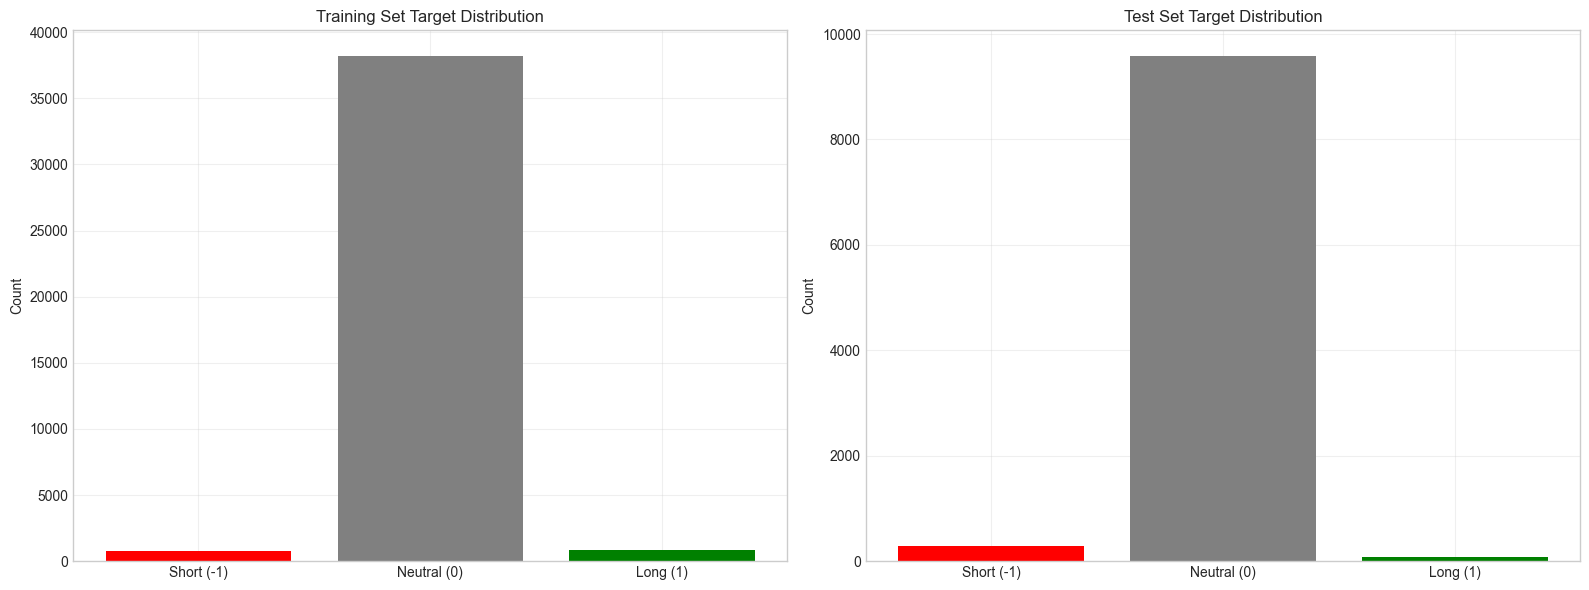

In [5]:
# Plot target distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training set
axes[0].bar(['Short (-1)', 'Neutral (0)', 'Long (1)'], 
          [train_target_counts.get(-1, 0), train_target_counts.get(0, 0), train_target_counts.get(1, 0)],
          color=['red', 'gray', 'green'])
axes[0].set_title('Training Set Target Distribution')
axes[0].set_ylabel('Count')
axes[0].grid(True, alpha=0.3)

# Test set
axes[1].bar(['Short (-1)', 'Neutral (0)', 'Long (1)'], 
          [test_target_counts.get(-1, 0), test_target_counts.get(0, 0), test_target_counts.get(1, 0)],
          color=['red', 'gray', 'green'])
axes[1].set_title('Test Set Target Distribution')
axes[1].set_ylabel('Count')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Create and Train Model

Now let's create and train our Random Forest model.

In [6]:
# Initialize model
model = RandomForestModel(
    n_estimators=100,
    max_depth=12,
    min_samples_split=10,
    random_state=42,
    profit_target=0.01,
    stop_loss=0.005
)

# Extract features and target
X_train, y_train = model.extract_features_target(df_train)
X_test, y_test = model.extract_features_target(df_test)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (39852, 31)
X_test shape: (9963, 31)


In [7]:
# Train the model
print("Training model...")
%time model.train(X_train, y_train)
print("Training completed!")

Training model...
CPU times: user 11.1 s, sys: 86.9 ms, total: 11.1 s
Wall time: 11.4 s
Training completed!


## 4. Model Evaluation

Let's evaluate the model's performance on both training and test data.

In [8]:
# Evaluate on training data
train_metrics = model.evaluate(X_train, y_train)
print("Training set metrics:")
for metric, value in train_metrics.items():
    print(f"  {metric}: {value:.4f}")

# Evaluate on test data
test_metrics = model.evaluate(X_test, y_test)
print("\nTest set metrics:")
for metric, value in test_metrics.items():
    print(f"  {metric}: {value:.4f}")

Training set metrics:
  accuracy: 0.9744
  precision: 0.9749
  recall: 0.9744
  f1_score: 0.9686

Test set metrics:
  accuracy: 0.7390
  precision: 0.9317
  recall: 0.7390
  f1_score: 0.8203


In [9]:
# Get detailed classification report
y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

          -1       0.04      0.30      0.06       285
           0       0.97      0.76      0.85      9590
           1       0.00      0.00      0.00        88

    accuracy                           0.74      9963
   macro avg       0.33      0.35      0.30      9963
weighted avg       0.93      0.74      0.82      9963



/Users/athapongkaewsalapoom/Development/experimental/trading/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/athapongkaewsalapoom/Development/experimental/trading/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/athapongkaewsalapoom/Development/experimental/trading/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_div

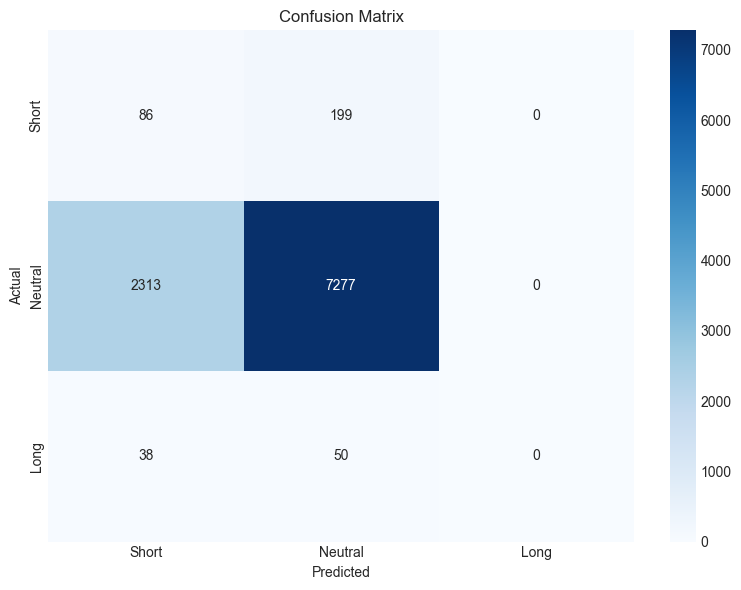

In [10]:
# Plot confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Short', 'Neutral', 'Long'] if len(set(y_test)) == 3 else ['Neutral', 'Long'],
           yticklabels=['Short', 'Neutral', 'Long'] if len(set(y_test)) == 3 else ['Neutral', 'Long'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

## 5. Feature Importance Analysis

Let's analyze which features were most important in our model.

In [11]:
# Get feature importance
feature_importance = model.get_feature_importance()
print("Top 15 important features:")
feature_importance.head(15)

Top 15 important features:


,Feature,Importance
16,Close_SMA200_Ratio,0.0981
2,SMA200,0.0816
1,SMA50,0.0705
4,EMA26,0.0641
3,EMA12,0.0598
11,BB_Middle,0.0549
0,SMA20,0.0523
9,ATR,0.0513
12,BB_Lower,0.0511
10,BB_Upper,0.0505


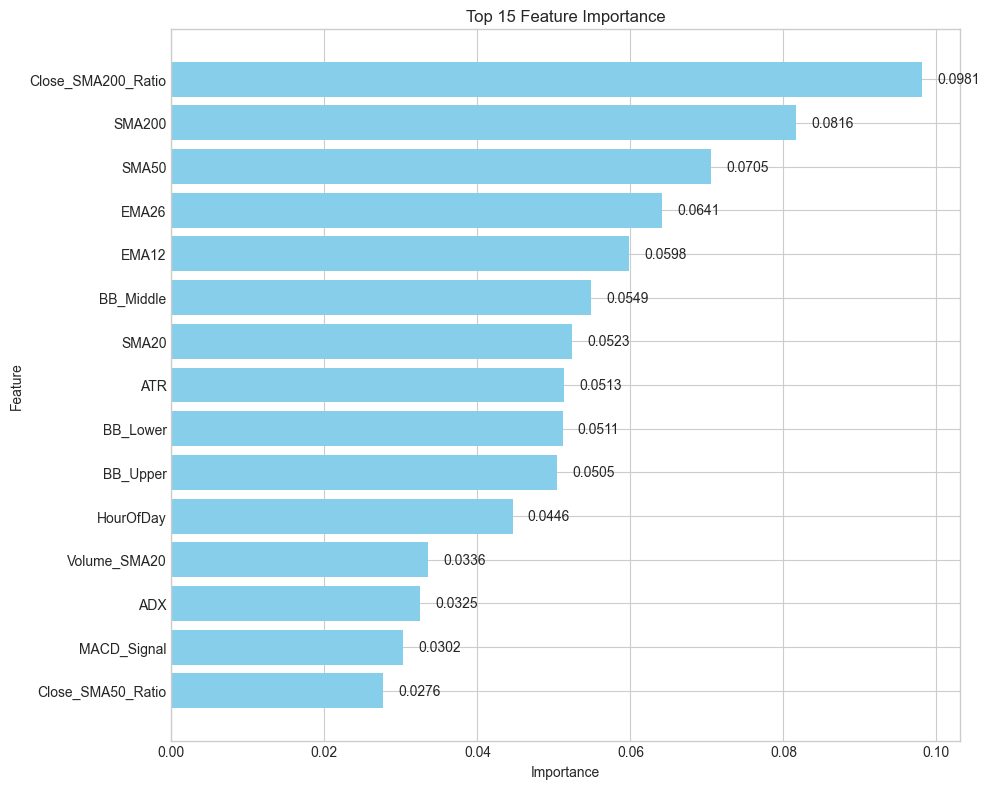

In [12]:
# Plot feature importance
fig = plot_feature_importance(feature_importance, top_n=15)
plt.tight_layout()
plt.show()

## 6. Cross-Validation with Time Series Split

Let's perform time series cross-validation to get a more robust estimate of our model's performance.

In [13]:
# Extract all features and target
X, y = model.extract_features_target(df_features)

# Set up time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Performance metrics for each fold
cv_scores = []

for train_idx, test_idx in tscv.split(X):
    # Get train/test split for this fold
    X_train_fold, X_test_fold = X[train_idx], X[test_idx]
    y_train_fold, y_test_fold = y[train_idx], y[test_idx]
    
    # Create and train a new model
    fold_model = RandomForestModel(
        n_estimators=100,
        max_depth=12,
        min_samples_split=10,
        random_state=42
    )
    
    # Train the model
    fold_model.train(X_train_fold, y_train_fold)
    
    # Evaluate the model
    metrics = fold_model.evaluate(X_test_fold, y_test_fold)
    cv_scores.append(metrics)
    
    print(f"Fold {len(cv_scores)} - Accuracy: {metrics['accuracy']:.4f}, F1 Score: {metrics['f1_score']:.4f}")

Fold 1 - Accuracy: 0.9772, F1 Score: 0.9660
Fold 2 - Accuracy: 0.9737, F1 Score: 0.9608
Fold 3 - Accuracy: 0.9730, F1 Score: 0.9597
Fold 4 - Accuracy: 0.9339, F1 Score: 0.9019
Fold 5 - Accuracy: 0.7155, F1 Score: 0.8102


In [14]:
# Calculate average metrics across folds
avg_metrics = {}
for metric in cv_scores[0].keys():
    avg_metrics[metric] = np.mean([fold[metric] for fold in cv_scores])

print("Average metrics across folds:")
for metric, value in avg_metrics.items():
    print(f"  {metric}: {value:.4f}")

Average metrics across folds:
  accuracy: 0.9147
  precision: 0.9341
  recall: 0.9147
  f1_score: 0.9197


## 7. Prediction Explanation

Let's examine some specific predictions and get explanations for them.

In [15]:
# Get test set predictions
test_pred = model.predict(X_test)
test_proba = model.predict_proba(X_test)

# Find some interesting predictions
# 1. A high confidence correct prediction
high_conf_correct = []
# 2. A low confidence prediction
low_conf = []
# 3. An incorrect prediction
incorrect = []

for i in range(len(test_pred)):
    pred = test_pred[i]
    actual = y_test[i]
    
    # Get prediction probability
    if pred == 0:
        prob = test_proba[i][0]
    elif pred == 1 and len(test_proba[i]) > 1:
        prob = test_proba[i][1]
    elif pred == -1 and len(test_proba[i]) > 2:
        prob = test_proba[i][2]
    else:
        prob = test_proba[i][0]
    
    # Check prediction categories
    if pred == actual and prob > 0.8 and len(high_conf_correct) < 1:
        high_conf_correct.append(i)
    elif 0.5 < prob < 0.6 and len(low_conf) < 1:
        low_conf.append(i)
    elif pred != actual and len(incorrect) < 1:
        incorrect.append(i)
    
    # Break if we found examples for all categories
    if len(high_conf_correct) >= 1 and len(low_conf) >= 1 and len(incorrect) >= 1:
        break

In [16]:
# Get explanations for interesting predictions
if high_conf_correct:
    print("Explanation for high confidence correct prediction:")
    idx = high_conf_correct[0]
    explanation = model.explain_prediction(X_test[idx], test_pred[idx], test_proba[idx])
    print(f"Date: {df_test.index[idx]}")
    print(f"Actual: {y_test[idx]}, Predicted: {test_pred[idx]}, Confidence: {explanation['confidence']:.2%}")
    print(explanation['explanation'])
    print("\n" + "-"*80)

if low_conf:
    print("\nExplanation for low confidence prediction:")
    idx = low_conf[0]
    explanation = model.explain_prediction(X_test[idx], test_pred[idx], test_proba[idx])
    print(f"Date: {df_test.index[idx]}")
    print(f"Actual: {y_test[idx]}, Predicted: {test_pred[idx]}, Confidence: {explanation['confidence']:.2%}")
    print(explanation['explanation'])
    print("\n" + "-"*80)

if incorrect:
    print("\nExplanation for incorrect prediction:")
    idx = incorrect[0]
    explanation = model.explain_prediction(X_test[idx], test_pred[idx], test_proba[idx])
    print(f"Date: {df_test.index[idx]}")
    print(f"Actual: {y_test[idx]}, Predicted: {test_pred[idx]}, Confidence: {explanation['confidence']:.2%}")
    print(explanation['explanation'])


Explanation for incorrect prediction:
Date: 2024-08-22 17:30:00+07:00
Actual: -1, Predicted: 0, Confidence: 0.30%
Predicted no significant move with 0.3% confidence based on:
- Price is near SMA200 (1.00)
- SMA200 value is 19770.52
- SMA50 value is 19825.20
- EMA26 value is 19828.45
- EMA12 value is 19836.37

Recommendation: Stay on the sidelines, no clear trading opportunity


## 8. Save Trained Model

Let's save our trained model for use in backtesting and future predictions.

In [17]:
# Save the model
model_path = model.save('../trained_model.pkl')
print(f"Model saved to: {model_path}")

Model saved to: ../trained_model.pkl


## Summary

In this notebook, we've accomplished the following:

1. Loaded our preprocessed dataset
2. Split the data into training and test sets using a time-based approach
3. Created and trained a Random Forest model for predicting trading entry points
4. Evaluated the model's performance on both training and test data
5. Analyzed feature importance to understand what drives the model's predictions
6. Performed time series cross-validation for more robust performance estimates
7. Generated explanations for specific predictions
8. Saved our trained model for future use

Next, we'll use our trained model for backtesting to see how it would have performed in historical trading scenarios.